As always, our import statements:

In [41]:
from numpy import zeros, array, einsum, float32, sum, zeros_like, subtract
from numpy.lib.stride_tricks import as_strided
from matplotlib import pyplot as plt

The solution to this PDE

$$\frac{{\partial ^2 u}}{{\partial t^2 }} = {{c^2 \Delta u}}$$

otherwise known as the wave equation is given by the following discrete set of equations:

$$
\begin{align}
 u_0(x,y) &= C\\
 u_{n+1}(x,y) &= u_n(x,y) + u'_n(x,y) \delta t\\
 u'_{n+1}(x,y) &= u'_n(x,y) + (c^2 \Delta u ) \delta t\\
\end{align}
$$

Here, since the equation is 2-D dimensional, it can be broken into matrix operations as a numerical solution.  As such, the following code are initial conditions taken from the [CompPhys](https://github.com/ubsuny/CompPhys/blob/PDEupdate/PDEs/ConvolutionPDE.ipynb) directory:

In [21]:
# Image size
N = 51
n = 50

# u and u'
u_init = zeros([N, N], dtype = float32)
up_init = zeros([N, N], dtype = float32)

# Initial condition on u
u_init[N//2, N//2] = 10

We can also introduce a Laplacian $L$, which acts as a convolution filter:

In [7]:
L = array([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]])

**(A.)** _solution by loops_

Then, we can create a function out of the numerical solution such that it can be timed.  Since this method is iterative, as defined on $n$, we must therefore pass in some max iteration.  Note that this code is also taken from the CompPhys directory, but modified to more closely suit our purpose:

In [17]:
def convolution_solution(u, up, L, n):

    U = u.copy()
    Up = up.copy()
    
    Un = zeros_like(U)
    
    for k in range(0, n):
        for i in range(1, U.shape[0] - 2):
            for j in range(1, U.shape[1] - 2):
                
                Un[i + 1, j + 1] = sum(L*U[i:i + 3, j:j + 3])/8.
                
        U  = U + Up
        Up = Up + 1/4 * Un
        
    return U

So, what does this look like for our initial conditions? 

In [33]:
sln = convolution_solution(u_init, up_init, L, n)

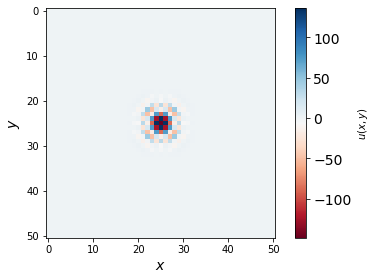

In [61]:
fig, ax = plt.subplots(1, 1)

I = ax.imshow(sln, 'RdBu')

ax.set_ylabel('$y$', fontsize = 14)
ax.set_xlabel('$x$', fontsize = 14)

cbar = fig.colorbar(I, label = '$u(x, y)$')
cbar.ax.tick_params(labelsize = 14)

fig.tight_layout();

It's great that we can solve this - that is perfectly fine.  However, how long does this actually take? Since the initial conditions are precisely the same each time, we can opt to only do different runs, not iterations.

In [34]:
%timeit -r 10 convolution_solution(u_init, up_init, L, n)

769 ms ± 19.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


As to be expected with Python loops...but we can do better...

**(B.)** _vectorized solution_

In [77]:
import scipy

In [79]:
def vectorized_solution(u, up, L, n):

    U = u.copy()
    Up = up.copy()
    
    Un = zeros_like(U)
    
    def conv_u(U, L):
        strides_shape = tuple(subtract(U.shape, L.shape) + 1) + L.shape
        strides = U.strides + U.strides
        matrices = as_strided(U, strides_shape, strides)
        m = einsum('ij, klij->kl', L, matrices)
        return m
    
    for i in range(n):
        Un[1:-1, 1:-1] = conv_u(U, L)
        U  = U + Up
        Up = Up + 1./4. * Un

    return U

In [80]:
%timeit -r 10 vectorized_solution(u_init, up_init, L, n)

6.54 ms ± 308 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


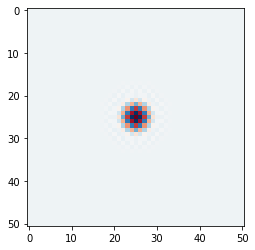

In [85]:
plt.imshow(vectorized_solution(u_init, up_init, L, n), 'RdBu')

In [ ]:
# This isn't right, so time to try again.